In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/temp_clean.csv")

In [ ]:
df.shape

(9952, 13)

In [ ]:
df.columns

Index(['Unnamed: 0', 'id', 'title', 'rating', 'user/userLocation/shortName',
       'placeInfo/id', 'placeInfo/name', 'placeInfo/rating', 'reply',
       'cleaned_review', 'cleaned_reply', 'cleaned_review2',
       'cleaned_response2'],
      dtype='object')

In [ ]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
df.drop(columns=['cleaned_review', 'cleaned_reply'], inplace=True)

In [ ]:
df['rating'].value_counts()

,count
rating,
5,4936
3,1703
4,1323
1,1260
2,730


In [ ]:
df.columns

Index(['id', 'title', 'rating', 'user/userLocation/shortName', 'placeInfo/id',
       'placeInfo/name', 'placeInfo/rating', 'reply', 'cleaned_review2',
       'cleaned_response2'],
      dtype='object')

In [ ]:
df2 = df.drop_duplicates(
    subset=[
        'placeInfo/id',
        'reply',
        'placeInfo/name',
        'placeInfo/rating',
        'title',
        'rating',
        'user/userLocation/shortName'
    ],
    keep='first',   # keeps the first occurrence; use 'last' if you prefer the last one
)


In [ ]:
df2.shape

(7436, 10)

In [ ]:
df2['rating'].value_counts()

,count
rating,
5,4867
4,1323
3,575
1,424
2,247


In [ ]:
df = df2

In [ ]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.6/23.6 MB 111.4 MB/s eta 0:00:00


In [ ]:
df.columns

Index(['id', 'title', 'rating', 'user/userLocation/shortName', 'placeInfo/id',
       'placeInfo/name', 'placeInfo/rating', 'reply', 'cleaned_review2',
       'cleaned_response2'],
      dtype='object')

In [ ]:
%%writefile retrieval.py

import numpy as np
import pandas as pd
import faiss
from sentence_transformers import SentenceTransformer

class ReviewRetrieval:
    """
    Retrieval module for hotel review–response generation.

    Responsibilities:
    - Encode all review texts into embeddings.
    - Build a FAISS index for fast similarity search.
    - Retrieve top-k manager replies for any new review.

    Inputs:
    - DataFrame with columns:
        ['cleaned_review', 'ownerResponse/text']

    Outputs:
    - A list of retrieved past manager responses.
    """

    def __init__(self, df, model_name="sentence-transformers/all-mpnet-base-v2",
                 embed_col="cleaned_review2",
                 reply_col="cleaned_response2",
                 use_gpu=True):

        self.df = df
        self.embed_col = embed_col
        self.reply_col = reply_col

        # Load embedding model (SBERT)
        print(f"Loading model: {model_name} ...")
        self.model = SentenceTransformer(model_name)

        if use_gpu:
            try:
                self.model = self.model.to('cuda')
                print("Using GPU for embeddings.")
            except:
                print("GPU not available. Falling back to CPU.")

        # Build embeddings + FAISS index
        self.build_index()

    # ---------------------------------------------------------
    # STEP 1 — Encode all dataset reviews and build index
    # ---------------------------------------------------------
    def build_index(self):
        print("Encoding all reviews into embeddings...")

        reviews = self.df[self.embed_col].fillna("").tolist()
        embeddings = self.model.encode(
            reviews,
            batch_size=32,
            convert_to_numpy=True,
            normalize_embeddings=True,
            show_progress_bar=True
        )
        self.embeddings = embeddings.astype("float32")

        print("Building FAISS index...")
        dim = self.embeddings.shape[1]
        self.index = faiss.IndexFlatIP(dim)   # cosine = dot product (after normalization)
        self.index.add(self.embeddings)

        print(f"FAISS index built. Number of items: {self.index.ntotal}")

    # ---------------------------------------------------------
    # STEP 2 — Encode query review
    # ---------------------------------------------------------
    def encode_query(self, query_text):
        query_emb = self.model.encode(
            [query_text],
            convert_to_numpy=True,
            normalize_embeddings=True
        ).astype("float32")
        return query_emb

    # ---------------------------------------------------------
    # STEP 3 — Retrieve top-k similar past replies
    # ---------------------------------------------------------
    def retrieve(self, query_text, top_k=5):
        if not isinstance(query_text, str) or len(query_text.strip()) == 0:
            return []

        query_emb = self.encode_query(query_text)
        distances, indices = self.index.search(query_emb, top_k)

        # Extract corresponding manager replies
        replies = self.df.iloc[indices[0]][self.reply_col].tolist()

        return replies

    # ---------------------------------------------------------
    # Optional: retrieve (review, reply) pairs for debugging
    # ---------------------------------------------------------
    def retrieve_pairs(self, query_text, top_k=5):
        query_emb = self.encode_query(query_text)
        distances, indices = self.index.search(query_emb, top_k)

        results = []
        for idx in indices[0]:
            row = self.df.iloc[idx]
            results.append({
                "review": row[self.embed_col],
                "response": row[self.reply_col]
            })
        return results


Writing retrieval.py


In [ ]:
df["review_length"] = df["cleaned_review2"].astype(str).str.len()
df["reply_length"] = df["cleaned_response2"].astype(str).str.len()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

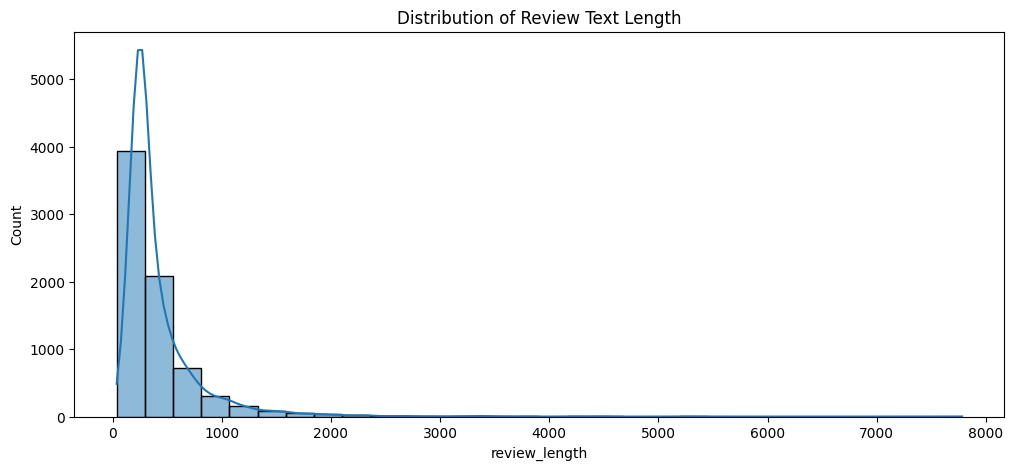

In [ ]:
plt.figure(figsize=(12,5))
sns.histplot(df['review_length'], bins=30, kde=True)
plt.title("Distribution of Review Text Length")
plt.show()

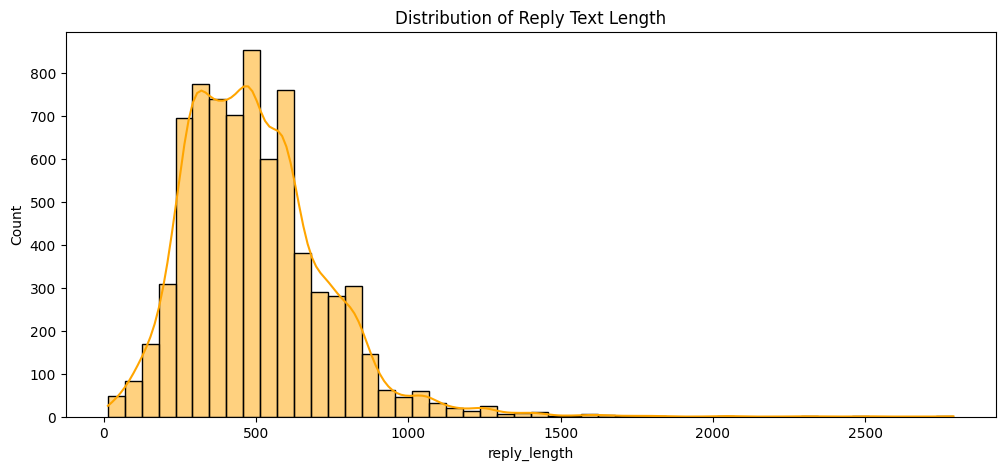

In [ ]:
plt.figure(figsize=(12,5))
sns.histplot(df['reply_length'], bins=50, kde=True, color="orange")
plt.title("Distribution of Reply Text Length")
plt.show()

In [ ]:
df = df[df['reply_length'] <= 1200]

In [ ]:
df.shape

(7356, 12)

In [ ]:
df['rating'].value_counts()

,count
rating,
5,4861
4,1315
3,562
1,389
2,229


In [ ]:
df.columns

Index(['id', 'title', 'rating', 'user/userLocation/shortName', 'placeInfo/id',
       'placeInfo/name', 'placeInfo/rating', 'reply', 'cleaned_review2',
       'cleaned_response2', 'review_length', 'reply_length',
       'review_sentiment'],
      dtype='object')

In [ ]:
from textblob import TextBlob

def get_sentiment(text):
    if not isinstance(text, str):
        return None
    polarity = TextBlob(text).sentiment.polarity
    return polarity

df['review_sentiment'] = df['cleaned_review2'].apply(get_sentiment)

In [ ]:
pos_df = df[df["rating"] >= 4].reset_index(drop=True)
neg_df = df[df["rating"] <= 2].reset_index(drop=True)

In [ ]:
df3 = df[df['rating'] == 3]
pos3 = df3[df3['review_sentiment'] >= 0].reset_index(drop=True)
neg3 = df3[df3['review_sentiment'] < 0].reset_index(drop=True)
pos_df = pd.concat([pos_df, pos3]).reset_index(drop=True)
neg_df = pd.concat([neg_df, neg3]).reset_index(drop=True)
pos_df = pos_df.sample(frac=1, random_state=42).reset_index(drop=True)
neg_df = neg_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
pos_df.shape

(6698, 13)

In [ ]:
neg_df.shape

(738, 13)

In [ ]:
pos_df.to_csv('positive_reviews.csv')
neg_df.to_csv('negative_reviews.csv')

In [ ]:
from sklearn.model_selection import train_test_split

# Split positive reviews
train_pos, temp_pos = train_test_split(pos_df, test_size=0.2, random_state=42)
val_pos, test_pos = train_test_split(temp_pos, test_size=0.5, random_state=42)

# Split negative reviews
train_neg, temp_neg = train_test_split(neg_df, test_size=0.2, random_state=42)
val_neg, test_neg = train_test_split(temp_neg, test_size=0.5, random_state=42)

In [ ]:
print(train_pos.shape)
print(val_pos.shape)
print(test_pos.shape)

(5358, 13)
(670, 13)
(670, 13)


In [ ]:
test_neg[test_neg['rating']==3].head(10)

,id,title,rating,user/userLocation/shortName,placeInfo/id,placeInfo/name,placeInfo/rating,reply,cleaned_review2,cleaned_response2,review_length,reply_length,review_sentiment
506,6871,Barely Makes it to the mark,3,Kolkata (Calcutta),482013,Hotel Kohinoor Continental,4.1,"Dear Guest, \n\nGreetings from Hotel Kohinoor ...",Having stayed in the hotel for multiple occass...,"Dear Guest, Greetings from <HOTEL_NAME> ! We a...",931,576,-0.018869
340,9439,Poor Room Service,3,NaN,1438191,Indismart Hotel,3.9,"Dear Guest,\nGreetings from Indismart Kolkata ...",The room service has gone down a lot.,"Dear Guest, Greetings from PERSON NAME ! It is...",37,623,-0.155556
588,7575,Normal hotel,3,Al Khobar,3575720,Kings Kastle,3.6,"Dear Sir,\n\nThank you for sharing your feedba...",I got a stinky room allocated to me . I had to...,"Dear Sir, Thank you for sharing your feedback ...",246,648,-0.095833
55,6968,Family vacation at Taj Exotica,3,Dubai,477574,"Taj Exotica Resort & Spa, <LOCATION>",4.7,"Dear Abhilash, \n\nGreetings from Taj Exotica ...","The property is excellent, however the pool is...","Dear Abhilash, Greetings from <HOTEL_NAME> . A...",383,646,-0.062500
702,6592,Miss this Resort if ur travelling for leisure ...,3,Pune,306969,Caravela Beach Resort,4.6,"Dear Arjun,\n \nThank you for your time and va...","The food experience was horrible, if u go at c...",<HOTEL_NAME> Thank you for your time and valua...,290,472,-0.095000
611,6790,Good location just at the right distance from ...,3,Gurugram (Gurgaon),1156304,Hotel Mall Palace,3.7,"Dear Guest, \nGreetings from Hotel Mall Palac...",We visited in diwali vacation and reached 3 ho...,"Dear Guest, Greetings from <HOTEL_NAME> ! Than...",224,250,-0.125000
643,7375,Passable. Better hotels in the vicinity. This ...,3,Dehradun,4884442,Holiday Inn New Delhi Aerocity By IHG,4.6,"Dear Guest,\nThank you for sharing your feedba...","The rooms badly need renovation, and housekeep...","Dear Guest, Thank you for sharing your feedbac...",423,481,-0.150000
81,7665,average,3,NaN,8728730,Golden Castle,4.0,"Dear Guest,\n\nWe are sorry for the inconvenie...",Though the room wad ok; the service was pathet...,"Dear Guest, We are sorry for the inconvenience...",220,438,-0.133333
590,7529,Looks Good but provides Poor Service,3,NaN,3575720,Kings Kastle,3.6,"Dear Sir,\n\nThank you for sharing your feedba...",The room which was given to us was good lookin...,"Dear Sir, Thank you for sharing your feedback ...",315,648,-0.006250
254,6511,"average to stay, bad for dining",3,New Delhi,3529823,Seegreen Lodges,4.7,"Dear Guest, \n\nThank you so much for taking t...",We stayed their for a day. Rooms were pretty d...,"Dear Guest, Thank you so much for taking the t...",716,279,-0.079905


In [ ]:
print(train_neg.shape)
print(val_neg.shape)
print(test_neg.shape)

(590, 13)
(74, 13)
(74, 13)


In [ ]:
from retrieval import ReviewRetrieval

retriever_pos = ReviewRetrieval(train_pos)
retriever_neg = ReviewRetrieval(train_neg)

Loading model: sentence-transformers/all-mpnet-base-v2 ...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
def build_prompt(review_text, retrieved_replies, sentiment="positive"):
    """
    Builds the training prompt for the generator.
    """
    sent_tag = "<POSITIVE>" if sentiment == "positive" else "<NEGATIVE>"

    retrieved_block = ""
    for i, r in enumerate(retrieved_replies):
        retrieved_block += f"[EXAMPLE_{i+1}] {r}\n"

    prompt = f"""
Instruction:
Generate a professional, context-aware manager reply to the guest review.

Sentiment: {sent_tag}

Review:
{review_text}

Relevant Past Replies:
{retrieved_block}

Manager Reply:
    """.strip()
    return prompt


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration, get_linear_schedule_with_warmup
from torch.optim import AdamW
from tqdm import tqdm
import pandas as pd
import numpy as np

# Training

In [ ]:
class GeneratorDataset(Dataset):
    def __init__(self, df, retriever, tokenizer, sentiment="positive", max_len=512):
        self.df = df
        self.retriever = retriever
        self.tokenizer = tokenizer
        self.sentiment = sentiment
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        review = row["cleaned_review2"]
        reply = row["cleaned_response2"]

        retrieved = self.retriever.retrieve(review, top_k=3)
        prompt = build_prompt(review, retrieved, sentiment=self.sentiment)

        enc = self.tokenizer(prompt, max_length=self.max_len, truncation=True, padding="max_length", return_tensors="pt")
        dec = self.tokenizer(reply, max_length=200, truncation=True, padding="max_length", return_tensors="pt")

        return {
            "input_ids": enc["input_ids"].squeeze(),
            "attention_mask": enc["attention_mask"].squeeze(),
            "labels": dec["input_ids"].squeeze()
        }


In [ ]:
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")

In [ ]:
train_dataset_pos = GeneratorDataset(train_pos, retriever_pos, tokenizer, sentiment="positive")
val_dataset_pos = GeneratorDataset(val_pos, retriever_pos, tokenizer, sentiment="positive")

train_dataset_neg = GeneratorDataset(train_neg, retriever_neg, tokenizer, sentiment="negative")
val_dataset_neg = GeneratorDataset(val_neg, retriever_neg, tokenizer, sentiment="negative")

train_loader_pos = DataLoader(train_dataset_pos, batch_size=4, shuffle=True)
val_loader_pos = DataLoader(val_dataset_pos, batch_size=4, shuffle=False)

train_loader_neg = DataLoader(train_dataset_neg, batch_size=4, shuffle=True)
val_loader_neg = DataLoader(val_dataset_neg, batch_size=4, shuffle=False)

NameError: name 'tokenizer' is not defined

In [ ]:
def train_generator(model, dataloader, val_loader, epochs=3, lr=3e-5):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)

    optimizer = AdamW(model.parameters(), lr=lr)
    total_steps = len(dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * total_steps),
        num_training_steps=total_steps
    )

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1} Training Loss: {avg_loss:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                val_loss += outputs.loss.item()

        print(f"Epoch {epoch+1} Validation Loss: {val_loss/len(val_loader):.4f}")

    return model


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Positive Generator
model_pos = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")
print("Training Positive Generator...")
model_pos = train_generator(model_pos, train_loader_pos, val_loader_pos, epochs=3)
model_pos.save_pretrained("generator_positive")
tokenizer.save_pretrained("generator_positive")

# Negative Generator
model_neg = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")
print("Training Negative Generator...")
model_neg = train_generator(model_neg, train_loader_neg, val_loader_neg, epochs=3)
model_neg.save_pretrained("generator_negative")
tokenizer.save_pretrained("generator_negative")

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Training Positive Generator...


Epoch 1/3: 100%|██████████| 1335/1335 [20:28<00:00,  1.09it/s]


Epoch 1 Training Loss: 1.9209
Epoch 1 Validation Loss: 1.5648


Epoch 2/3: 100%|██████████| 1335/1335 [19:50<00:00,  1.12it/s]


Epoch 2 Training Loss: 0.0256
Epoch 2 Validation Loss: 1.5155


Epoch 3/3: 100%|██████████| 1335/1335 [19:51<00:00,  1.12it/s]


Epoch 3 Training Loss: 0.0218
Epoch 3 Validation Loss: 1.5191
Training Negative Generator...


Epoch 1/3: 100%|██████████| 137/137 [02:01<00:00,  1.13it/s]


Epoch 1 Training Loss: 6.7502
Epoch 1 Validation Loss: 2.2899


Epoch 2/3: 100%|██████████| 137/137 [02:02<00:00,  1.12it/s]


Epoch 2 Training Loss: 0.3967
Epoch 2 Validation Loss: 1.8957


Epoch 3/3: 100%|██████████| 137/137 [02:02<00:00,  1.12it/s]


Epoch 3 Training Loss: 0.1834
Epoch 3 Validation Loss: 1.8563


('generator_negative/tokenizer_config.json',
 'generator_negative/special_tokens_map.json',
 'generator_negative/spiece.model',
 'generator_negative/added_tokens.json')

In [ ]:
!cp -r /content/generator_positive "/content/drive/My Drive/"

In [ ]:
!cp -r /content/generator_negative "/content/drive/My Drive/"

# Inference

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_path_pos = "/content/drive/MyDrive/generator_positive"
model_path_neg = "/content/drive/MyDrive/generator_negative"

In [ ]:
tokenizer_pos = T5Tokenizer.from_pretrained(model_path_pos)
model_pos = T5ForConditionalGeneration.from_pretrained(model_path_pos)

tokenizer_neg = T5Tokenizer.from_pretrained(model_path_neg)
model_neg = T5ForConditionalGeneration.from_pretrained(model_path_neg)

In [ ]:
!pip install ftfy emoji langdetect rapidfuzz

In [ ]:
import re
import ftfy
import emoji
import unicodedata
from langdetect import detect
import spacy
from rapidfuzz import fuzz

nlp = spacy.load("en_core_web_sm")

class TextCleaner:

    def __init__(self, fuzzy_threshold=80):
        self.fuzzy_threshold = fuzzy_threshold

    # -----------------------------------------------------------
    # 1. Language check
    # -----------------------------------------------------------
    def is_english(self, text):
        try:
            return detect(text) == "en"
        except:
            return False

    # -----------------------------------------------------------
    # 2. Remove gibberish
    # -----------------------------------------------------------
    def is_gibberish(self, text, threshold=0.5):
        if not isinstance(text, str) or len(text.strip()) == 0:
            return True

        alpha = sum(c.isalpha() for c in text)
        total = len(text)
        if total == 0:
            return True

        return (alpha / total) < threshold

    # -----------------------------------------------------------
    # 3. Basic unicode + noise removal
    # -----------------------------------------------------------
    def basic_clean(self, text):
        if not isinstance(text, str):
            return ""

        text = unicodedata.normalize("NFKD", text)
        text = ftfy.fix_text(text)
        text = emoji.replace_emoji(text, replace=" ")

        # Remove strange characters
        text = re.sub(r"[^A-Za-z0-9\s.,;:?!'\"()\-/%&]", " ", text)
        text = re.sub(r"\s+", " ", text).strip()
        return text

    # -----------------------------------------------------------
    # 4. Remove contact info
    # -----------------------------------------------------------
    def clean_contact_info(self, text):
        if not isinstance(text, str):
            return text

        text = re.sub(r'\b[\w\.-]+@[\w\.-]+\.\w+\b', '<EMAIL>', text)
        text = re.sub(r'https?://\S+|www\.\S+', '<URL>', text)
        text = re.sub(r'(\+?\d[\d\-\s]{8,}\d)', '<PHONE>', text)
        return text

    # -----------------------------------------------------------
    # 5. Replace PERSON / ORG / LOCATION entities
    # -----------------------------------------------------------
    def replace_entities(self, text):
        if not isinstance(text, str) or len(text.strip()) == 0:
            return text

        doc = nlp(text)
        ents = sorted(doc.ents, key=lambda e: len(e.text), reverse=True)
        new_text = text

        for ent in ents:
            label = ent.label_
            ent_text = re.escape(ent.text)

            if label == "PERSON":
                new_text = re.sub(rf"\b{ent_text}\b", "<PERSON_NAME>", new_text, flags=re.IGNORECASE)

            elif label in ["ORG"]:
                new_text = re.sub(rf"\b{ent_text}\b", "<HOTEL_NAME>", new_text, flags=re.IGNORECASE)

            elif label in ["GPE", "LOC"]:
                new_text = re.sub(rf"\b{ent_text}\b", "<LOCATION>", new_text, flags=re.IGNORECASE)

        new_text = re.sub(r"\s{2,}", " ", new_text).strip()
        return new_text

    # -----------------------------------------------------------
    # 6. Fix salutations ("Dear John" → "Dear Guest")
    # -----------------------------------------------------------
    def normalize_salutation(self, text):
        if not isinstance(text, str):
            return text

        text = re.sub(
            r"(?i)\bDear\s+[A-Z][a-zA-Z]+\b",
            "Dear Guest",
            text
        )
        return text

    # -----------------------------------------------------------
    # 7. Fuzzy replace hotel name when known
    # -----------------------------------------------------------
    def fuzzy_replace_hotel(self, text, hotel_name):
        if not hotel_name or not isinstance(text, str):
            return text

        t = text.lower()
        h = str(hotel_name).lower()

        score = fuzz.partial_ratio(h, t)
        if score >= self.fuzzy_threshold:
            return re.sub(re.escape(hotel_name), "<HOTEL_NAME>", text, flags=re.IGNORECASE)

        return text

    # -----------------------------------------------------------
    # ✨ MAIN CLEAN FUNCTION (call this)
    # -----------------------------------------------------------
    def clean(self, text, hotel_name=None):
        if text is None:
            return ""

        text = str(text)

        # 1. English check + gibberish
        if not self.is_english(text):
            return ""
        if self.is_gibberish(text):
            return ""

        # 2. Basic clean
        text = self.basic_clean(text)

        # 3. Contact info
        text = self.clean_contact_info(text)

        # 4. Fuzzy replace hotel name (optional)
        if hotel_name:
            text = self.fuzzy_replace_hotel(text, hotel_name)

        # 5. spaCy entity replacement
        text = self.replace_entities(text)

        # 6. Fix salutations
        text = self.normalize_salutation(text)

        return text.strip()

In [ ]:
cleaner = TextCleaner(fuzzy_threshold=80)

def clean_review_for_inference(text, hotel_name=None, min_chars=20):
    """
    Clean a new incoming review with the same pipeline used in training.
    If cleaning collapses to empty (e.g., non-English/gibberish), fall back to a basic sanitize.
    """
    cleaned = cleaner.clean(text, hotel_name=hotel_name)
    if not isinstance(cleaned, str) or len(cleaned.strip()) < min_chars:
        # fallback so we don't feed empty query to retriever/model
        basic = cleaner.basic_clean(str(text))
        cleaned = basic if len(basic.strip()) >= min_chars else str(text).strip()
    return cleaned

In [ ]:
def clean_generated_reply(text, hotel_name=None):
    """
    Clean the model's own reply WITHOUT language/gibberish rejection,
    to avoid accidentally blanking a valid generation. Keeps the same anonymization rules.
    """
    if not isinstance(text, str):
        text = str(text)

    # Keep structure similar to your training clean, but skip language/gibberish checks.
    out = cleaner.basic_clean(text)
    out = cleaner.clean_contact_info(out)

    if hotel_name:
        out = cleaner.fuzzy_replace_hotel(out, hotel_name)

    # Replace entities & normalize salutations (like training)
    out = cleaner.replace_entities(out)
    out = cleaner.normalize_salutation(out)

    # Final tidy
    out = re.sub(r"\s{2,}", " ", out).strip()
    return out

In [ ]:
def generate_reply(review_text, rating=None, sentiment="auto", hotel_name=None):
    """
    Generate a manager reply with cleaning:
      - Clean the incoming review (same pipeline as training/testing).
      - Retrieve with the cleaned review.
      - Build prompt from the cleaned review.
      - Generate reply.
      - Clean the generated reply (contact info masking, entity redaction, salutations, etc.).
    """
    from textblob import TextBlob
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # 1) Determine sentiment (unchanged)
    if rating in [4, 5]:
        sentiment = "positive"
    elif rating in [1, 2]:
        sentiment = "negative"
    else:
        sentiment = "positive" if TextBlob(str(review_text)).sentiment.polarity > 0 else "negative"

    # 2) Select model/tokenizer/retriever (unchanged)
    if sentiment == "positive":
        model = model_pos.to(device)
        tokenizer = tokenizer_pos
        retriever = retriever_pos
    else:
        model = model_neg.to(device)
        tokenizer = tokenizer_neg
        retriever = retriever_neg

    # 3) Clean the incoming review BEFORE retrieval/prompting
    cleaned_review = clean_review_for_inference(review_text, hotel_name=hotel_name)

    # 4) Retrieve using the cleaned review
    retrieved = retriever.retrieve(cleaned_review, top_k=3)

    # 5) Build prompt from CLEANED review (unchanged otherwise)
    prompt = build_prompt(cleaned_review, retrieved, sentiment=sentiment)
    enc = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True).to(device)

    # 6) Generate reply (unchanged)
    outputs = model.generate(
        **enc,
        max_new_tokens=200,
        num_beams=5,
        no_repeat_ngram_size=3,
        early_stopping=True
    )
    raw_reply = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # 7) Clean the GENERATED reply (no lang/gibberish rejection)
    cleaned_reply = clean_generated_reply(raw_reply, hotel_name=hotel_name)

    # Guardrail: if cleaning over-removed content, fall back to raw (rare)
    if len(cleaned_reply.strip()) < 10:
        cleaned_reply = raw_reply.strip()

    return cleaned_reply


In [ ]:
import gradio as gr

def generate_reply_interface(rating, review_text):
    reply = generate_reply(review_text, rating=rating)
    return reply

ui = gr.Interface(
    fn=generate_reply_interface,
    inputs=[
        gr.Slider(1, 5, step=1, label="Hotel Rating (1 = bad, 5 = good)"),
        gr.Textbox(lines=8, label="Customer Review")
    ],
    outputs=gr.Textbox(lines=10, label="Generated Manager Reply"),
    title="Hotel Review → Manager Reply Generator",
    description="Enter a rating and review to generate a professional hotel manager response."
)

ui.launch(debug=True)


In [ ]:
generated_reply = generate_reply("	This hotel is not at all what it looks on the website. My office booked a super deluxe room online but they gave me a normal room because when I was checking in, the receptionist gave the room to someone else who paid twice the amount in cash. Extremely filthy rooms. They switch off the electricity, cable and stop the supply of water whenever they feel like because they have the main access outside the room. Pathetic experience. Neither will go back to this hotel nor will recommend to anyone")
print(generated_reply)

Dear Guest, We would like to thank you for choosing our hotel as your accommodation choice and for taking the time to post a review of your experience. I am disappointed to read that you didn t enjoy your stay with us. Please accept my sincere apologies for the challenges you encountered in our hotel. Please be assured that your feedback is being looked into and appropriate action is taken to prevent any guests being similarly inconvenienced in the future. It is our constant endeavor to offer our discerning guests, quality experience during their stay and I hope you will not let this incident mar your perception of our service standards and will give us another opportunity to serve you again. Regards


In [ ]:
gr2 = generate_reply('''This is no where 3 star hotel, this seems a dharamshala
No Room service provided, even intercom was not there in room
Restaurant is closed
Staff is not helpful and for even basic needs like water, towels you need to come downstairs and ask people for help
''')

In [ ]:
print(gr2)

Dear Sir, Thanks for your valuable feedback for our HOTEL_NAME>. We are sorry to hear that you did not enjoy your stay with us. However we try to improve Our services. We would welcome you once again in near future. Thanks and regards


In [ ]:
gr3 = generate_reply('''i stayed with my wife one night its was amazing experience great hospitality room boy and front office guys highly recommended thank you all of you.

Room rent is affordable house keeping well maintained the room very comfortable easy easy to travel anywhere from the hotel''')

In [ ]:
gr3

'Dear Guest, Thanks for choosing and staying with us during your recent visit to LOCATION>. We also appreciate your effort towards sharing your feedback on public platform which is always beneficial for other guest to find their stay. Looking forward to serve you again in near future. Regards, PERSON NAME General Manager'

In [ ]:
generate_reply('''My room was allotted on the fifth floor when I checked in at 11pm with my family. The health faucet was broken, then another room was changed where Air conditioning system was not working, then again changed room to a suite room where the tap of the wash basin was not fixed and had time to open and shut the tap as it was moving in all directions.
Would advise visitors to exercise caution.
I got a refund when I threatened to post my review in the local vernacular daily and Make My trip.com''')

'Dear Guest, Thank you very much for choosing to stay with us and sharing your feedback. Please accept my sincere apologies for the experience you had during your stay with nos. We are looking into the matter. Your valuable feedback will guide us in the right direction to be able to provide a truly delightful experience to our guests. I am disappointed that we fell short this time, but I hope you will give us further opportunities to serve you better. Best Regards, PERSON NAME , HOTEL_NAME>'

In [ ]:
generate_reply('''Was there beginning of the month, a moderate 3star budget hotel with basic facilities. The service staffs are from various countries but friendly even though there are not well versed with English. They tried to assist as much as they could immediately and promptly. Overall premises and rooms were kept clean even though minor things can be found. However, the facilities wise on obtaining iron, hairdryer, mineral water, extra towels or amenities was challenging. On last day of the departure met Mr Thiagaraj the hotel manager; he was friendly and willing to listen on The feedback. Kudos to Mathesh, his F&B team & FO team Shaam, Don & Sulaiman.
They are doing great job and keep it up. Improve on the minor issues and other than that it’s a great hotel to stay.''')

'Dear NAME , PERSON NAME from all of us at HOTEL NAME At the outset I would like to thank you for your wonderful review and expressing your kind sentiments. Thank you for Your valuable time in sharing your feedback and I am pleased to note that you had an enjoyable stay, and our services met and surpassed your expectations. I have also made a note of your detailed feedback and the areas highlighted and reassure you that the highlighted areas are being looked into. Sincerely regret the inconvenience caused. Once again thank you from your valuable time and we all look forward to welcoming you back whenever PERONE NAME is part of your next travel plans. Assuring you of our best of hospitality and services always . Warm regards,'

# Evaluation

In [ ]:
!pip install evaluate rouge-score nltk bert_score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.6 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=34daf24da2821d02610e1db46896a95288aa92af26c219eb7a82879f3dec868b
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score


In [ ]:
import evaluate
import numpy as np
import pandas as pd
from tqdm import tqdm
import nltk
nltk.download('punkt')
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
rouge = evaluate.load("rouge")
bertscore = evaluate.load("bertscore")

In [ ]:
def evaluate_model(model, tokenizer, retriever, df_sample, sentiment="positive", num_samples=50):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    model.eval()

    refs, preds = [], []

    for i in tqdm(range(min(num_samples, len(df_sample)))):
        review = df_sample["cleaned_review2"].iloc[i]
        true_reply = df_sample["cleaned_response2"].iloc[i]

        retrieved = retriever.retrieve(review, top_k=3)
        prompt = build_prompt(review, retrieved, sentiment=sentiment)
        enc = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True).to(device)

        with torch.no_grad():
            outputs = model.generate(
                **enc,
                max_new_tokens=200,
                num_beams=5,
                no_repeat_ngram_size=3,
                early_stopping=True
            )
        gen_reply = tokenizer.decode(outputs[0], skip_special_tokens=True)

        refs.append(true_reply)
        preds.append(gen_reply)

    # --- Compute metrics ---
    rouge_scores = rouge.compute(predictions=preds, references=refs)
    bert_scores = bertscore.compute(predictions=preds, references=refs, lang="en")

    smoothie = SmoothingFunction().method4
    bleu_scores = [sentence_bleu([r.split()], p.split(), smoothing_function=smoothie) for r, p in zip(refs, preds)]

    avg_bleu = np.mean(bleu_scores)
    avg_bert = np.mean(bert_scores["f1"])
    avg_len = np.mean([len(p.split()) for p in preds])

    return {
        "ROUGE-L": rouge_scores["rougeL"],
        "BLEU": avg_bleu,
        "BERTScore": avg_bert,
        "AvgGenLength": avg_len
    }


In [ ]:
# Positive model evaluation
print("Evaluating Positive Generator...")
results_pos = evaluate_model(model_pos, tokenizer_pos, retriever_pos, test_pos, sentiment="positive")
print(results_pos)

# Negative model evaluation
print("Evaluating Negative Generator...")
results_neg = evaluate_model(model_neg, tokenizer_neg, retriever_neg, test_neg, sentiment="negative")
print(results_neg)


Evaluating Positive Generator...


100%|██████████| 50/50 [04:08<00:00,  4.98s/it]


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'ROUGE-L': np.float64(0.29536291481614657), 'BLEU': np.float64(0.0954306713078515), 'BERTScore': np.float64(0.8730556404590607), 'AvgGenLength': np.float64(69.64)}
Evaluating Negative Generator...


100%|██████████| 50/50 [02:57<00:00,  3.55s/it]


{'ROUGE-L': np.float64(0.2236973293090699), 'BLEU': np.float64(0.047840761938877305), 'BERTScore': np.float64(0.8564225804805755), 'AvgGenLength': np.float64(81.24)}
